# 机器学习报告三:参数估计&非参估计
- 姓名：李欣
- 学号：2011165
- 专业：计算机科学与技术

## 一、基本要求

生成两个各包含 N=1200 个二维随机向量的数据集合  X1  和  X2 ，数据集合中随机向量来自于三个分布模型，分别满足均值向量  μ<sub>1</sub>=[1,4] , μ<sub>2</sub>=[4,1] ,  μ<sub>3</sub>=[8,4]  和协方差矩阵 D<sub>1</sub>=D<sub>2</sub>=D<sub>3</sub>=2I，其中I是2∗2的单位矩阵。在生成数据集合X<sub>1</sub>时，假设来自三个分布模型的先验概率相同；而在生成数据集合X<sub>2</sub>时，先验概率如下：p(w<sub>1</sub>)=0.6, p(w<sub>2</sub>)=0.1,p(w<sub>3</sub>)=0.3

1. 在两个数据集合上分别应用“似然率测试规则” 、“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。
2. 在两个数据集合上分别应用  h=1  时的方窗核函数或高斯核函数估计方法，应用“似然率测试规则”进行分类实验，计算分类错误率，分析实验结果。

### 生成数据集

#### 导入需要的包

In [34]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### 生成数据集的函数

In [2]:
# 生成正态分布数据
def Generate_Sample_Gaussian(mean, cov, P, label):
    '''
        mean 为均值向量
        cov 为方差矩阵a
        P 为单个类的先验概率
        return 单个类的数据集
    '''
    temp_num = round(1200 * P)
    x, y = np.random.multivariate_normal(mean, cov, temp_num).T
    z = np.ones(temp_num) * label
    X = np.array([x, y, z])
    return X.T

In [3]:
# 根据先验概率生成测试集并画出对应的图
def Generate_DataSet_plot(mean, cov, P):
    # 画出不同先验对应的散点图
    xx = []
    label = 1
    for i in range(3):
        xx.append(Generate_Sample_Gaussian(mean[i], cov, P[i], label))
        label += 1
        i = i + 1
    # 画图
    plt.figure()
    for i in range(3):
        plt.plot(xx[i][:, 0], xx[i][:, 1], '.', markersize=4.)
        plt.plot(mean[i][0], mean[i][1], 'r*')
    plt.show()
    # print(type(xx))
    # print(xx)
    return xx

In [4]:
# 根据先验概率生成测试集
def Generate_DataSet(mean, cov, P):
    # 按照先验概率生成正态分布数据
    # 返回所有类的数据集
    X = []
    label = 1
    for i in range(3):
    # 把此时类i对应的数据集加到已有的数据集中
    # 创建并将数据进行拼接
        X.extend(Generate_Sample_Gaussian(mean[i], cov, P[i], label))
        label += 1
        i = i + 1
    # print(type(X))
    # print(X)
    return X

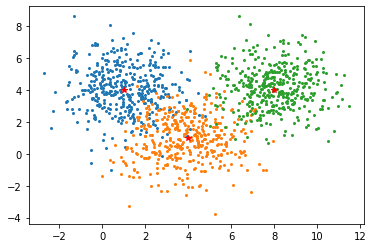

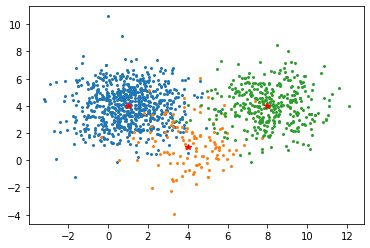

In [5]:
mean = np.array([[1, 4], [4, 1], [8, 4]])  # 均值数组
cov = [[2, 0], [0, 2]]  # 方差矩阵
num = 1200  # 样本个数
P1 = [1 / 3, 1 / 3, 1 / 3]  # 样本X1的先验概率
P2 = [0.6, 0.1, 0.3]  # 样本X2的先验概率
X1 = np.array(Generate_DataSet_plot(mean, cov, P1), dtype=object)
X2 = np.array(Generate_DataSet_plot(mean, cov, P2), dtype=object)
X1 = np.vstack(X1)
X2 = np.vstack(X2)
# X1
# X2

In [6]:
X1.shape, X2.shape  # 前两列是坐标，最后一列是标签
# type(X1)

((1200, 3), (1200, 3))

In [7]:
# Hint for 初级要求：二元高斯分布概率密度函数计算
# 在公式中，x和mean应该是列向量，但是为了方便，这里接收的都是行向量（维度：1*2）
def Gaussian_function(x, mu, cov):
    det_cov = np.linalg.det(cov)  # 计算方差矩阵的行列式
    inv_cov = np.linalg.inv(cov)  # 计算方差矩阵的逆
    # 计算概率p(x|w)
    p = 1 / (2 * np.pi * np.sqrt(det_cov)) * np.exp(-0.5 * np.dot(np.dot((x - mu), inv_cov), (x - mu).T))
    return p

In [8]:
# Hint for 初级要求：高斯核概率密度函数计算
# 在公式中，x和mean应该是列向量，但是为了方便，这里接收的都是行向量（维度：1*2）
def Gaussian_Kernel(x, X, h=2):
    # 计算概率p(x|w)
    # print(x)
    p = (1 / (np.sqrt(2 * np.pi) * h)) * np.array([np.exp(-0.5 * np.dot(x - X[i], x - X[i]) / (h**2)) for i in range(len(X))]).mean()
    return p

#### 似然率测试规则

In [9]:
# 似然率测试规则
def Likelihood_Test_Rule(X, mean, cov1,cov2,cov3, P):
    class_num = mean.shape[0]  # 类的个数 3
    num = np.array(X).shape[0]
    error_num = 0
    
    cov=None
    for i in range(num):
        p_temp = np.zeros(3)
        if X[i][2]==0:
            cov=cov1
        elif X[i][2]==1:
            cov=cov2
        elif X[i][2]==2:
            cov=cov3
            
        for j in range(class_num):
            # 计算样本i决策到j类的概率
            p_temp[j] = Gaussian_function(X[i][0:2], mean[j], cov)  
        p_class = np.argmax(p_temp)+1  # 得到样本i决策到的类
        # print(X[i][2])
        if p_class != X[i][2]:
            error_num += 1
    return round(error_num / num , 3)

In [10]:
def Kernel_Likelihood_Rule(X,h=1):
    class_num = mean.shape[0]  # 类的个数 3
    num = np.array(X).shape[0]
    error_num = 0
    count=[0,0,0]
    for i in range (len(X)):
        if X[i][2]==1:
            count[0]=count[0]+1
        elif X[i][2]==2:
            count[1]=count[1]+1
        elif X[i][2]==3:
            count[2]=count[2]+1

    X1=np.asarray(X)
    # 标签为1
    array_1=X1[0:count[0],0:2]
    # 标签为2
    array_2=X1[count[0]:count[0]+count[1],0:2]
    # 标签为3
    array_3=X1[count[0]+count[1]:count[0]+count[1]+count[2],0:2]    
    
    for i in range(num):
        p_temp = np.zeros(3)
        for j in range(class_num):
            # 计算样本i决策到j类的概率
            if j==0:
                p_temp[j] = Gaussian_Kernel(X[i][0:2], array_1, h )  
            elif j==1:
                p_temp[j] = Gaussian_Kernel(X[i][0:2], array_2, h )                  
            elif j==2:
                p_temp[j] = Gaussian_Kernel(X[i][0:2], array_3, h )                    
        p_class = np.argmax(p_temp)+1  # 得到样本i决策到的类
        # print(X[i][2])
        if p_class != X[i][2]:
            error_num += 1
    return round(error_num / num , 3)

In [11]:
def LikelyHood(X):
    
    count=[0,0,0]
    for i in range (len(X)):
        if X[i][2]==1:
            count[0]=count[0]+1
        elif X[i][2]==2:
            count[1]=count[1]+1
        elif X[i][2]==3:
            count[2]=count[2]+1
            
    # 标签为1
    array_1=X[0:count[0],0:2]
    # 标签为2
    array_2=X[count[0]:count[0]+count[1],0:2]
    # 标签为3
    array_3=X[count[0]+count[1]:count[0]+count[1]+count[2],0:2]

    mu=[np.mean(array_1,axis=0)]
    mu=np.append(mu,[np.mean(array_2,axis=0)],axis=0)
    mu=np.append(mu,[np.mean(array_3,axis=0)],axis=0)
    
    cov1 = np.array([np.dot((array_1[i] - mu[0]).reshape(2,1), (array_1[i] - mu[0]).reshape(1, 2)) for i in range(len(array_1))]).mean(axis=0)
    cov2 = np.array([np.dot((array_2[i] - mu[1]).reshape(2,1), (array_2[i] - mu[1]).reshape(1, 2)) for i in range(len(array_2))]).mean(axis=0)
    cov3 = np.array([np.dot((array_3[i] - mu[2]).reshape(2,1), (array_3[i] - mu[2]).reshape(1, 2)) for i in range(len(array_3))]).mean(axis=0)
    
    cov1=cov1.tolist()
    cov2=cov2.tolist()
    cov3=cov3.tolist()
    
    return mu, cov1,cov2,cov3

#### 最大后验概率规则

In [12]:
##最大后验概率规则
def Max_Posterior_Rule(X, mean, cov1,cov2,cov3, P):
    class_num = mean.shape[0]  # 类的个数
    # print(class_num)
    num = np.array(X).shape[0]
    error_num = 0
    cov=None
    for i in range(num):
        p_temp = np.zeros(3)
        if X[i][2]==0:
            cov=cov1
        elif X[i][2]==1:
            cov=cov2
        elif X[i][2]==2:
            cov=cov3
        # print(i,":",cov)
        for j in range(class_num):
            # 计算样本i是j类的后验概率
            p_temp[j] =Gaussian_function(X[i][0:2],mean[j],cov)*P[j]
        p_class = np.argmax(p_temp) + 1  # 得到样本i分到的类
        if p_class != X[i][2]:
            error_num += 1
    return round(error_num / num,3) # 保留三位小数

In [13]:
# 单次试验求不同准则下的分类误差
def repeated_trials(mean, cov, P1, P2):
    # 根据mean，cov，P1,P2生成数据集X1,X2
    # 通过不同规则得到不同分类错误率并返回
    # 生成N=1000的数据集
    X1 = Generate_DataSet(mean, cov, P1)
    # print(type(X1))
    X2 = Generate_DataSet(mean, cov, P2)
    error = np.zeros((3, 2))
    mean1,cov11,cov12,cov13=LikelyHood(np.array(X1))
    mean2,cov21,cov22,cov23=LikelyHood(np.array(X2))
    # 计算似然率测试规则误差()
    error_likelihood = Likelihood_Test_Rule(X1, mean1, cov11,cov12,cov13, P1)
    error_likelihood_2 = Likelihood_Test_Rule(X2, mean2, cov21,cov22,cov23, P2)
    error[0] = [error_likelihood, error_likelihood_2]
    # 计算最大后验概率规则误差
    error_Max_Posterior_Rule = Max_Posterior_Rule(X1, mean1, cov11,cov12,cov13, P1)
    error_Max_Posterior_Rule_2 = Max_Posterior_Rule(X2, mean2, cov21,cov22,cov23, P2)
    error[1] = [error_Max_Posterior_Rule, error_Max_Posterior_Rule_2]
    # 计算使用高斯核函数估计方法 最大似然率测试规则的计算误差
    error_kernel_Likelihood = Kernel_Likelihood_Rule(X1,h=1)
    error_kernel_Likelihood_2 = Kernel_Likelihood_Rule(X2,h=1)    
    error[2] = [error_kernel_Likelihood, error_kernel_Likelihood_2]
    return error

In [ ]:
    # print("type(cov)",type(cov))
    # 计算十次运算的总误差
    error_all = np.zeros((3, 2))
    # error_all
    # 测试times_num次求平均
    times_num = 10
    for times in range(times_num):
        error=repeated_trials(mean,cov,P1,P2)
        print("第{}次试验:      极大似然 最大后验 核函数极大似然".format(times+1))
        print("X1错误率:   \t{}  \t{}  \t{}".format(error[0][0],error[1][0],error[2][0]))
        print("X2错误率:   \t{}  \t{}  \t{}".format(error[0][1], error[1][1],error[2][1]))
        error_all += error
    # 计算平均误差
    error_ave = np.around(error_all / times_num,4)
    print("平均错误率:       极大似然         最大后验    核函数极大似然")
    print("X1错误率:  \t{}   \t{}  \t{}".format(error_ave[0][0],error_ave[1][0],error_ave[2][0]))
    print("X2错误率:  \t{}   \t{}  \t{}".format(error_ave[0][1],error_ave[1][1],error_ave[2][1]))

#### 结果分析

1. 在X1数据集上，似然率测试规则和最大后验概率测试规则错误率相同，这是由于，相较于似然率测试规则，后者只是在其结果上乘上了P，而P1=(1/3,1/3,1/3),由于P1[0]=P1[1]=P1[2],即使用前者和后者计算出来三类的概率相对大小固定，所以X1的极大似然和最大后验错误率相同。
2. 在X1数据集上，似然率测试规则和最大后验概率测试规则错误率相同，这是由于，相较于似然率测试规则，后者只是在其结果上乘上了P，而P2=(0.6,0.3,0.1),由于P2[0]>P2[1]>P2[2],即使用前者和后者计算出来三类的概率相对大小并不固定，所以X1的极大似然和最大后验错误率不相同，相比之下，最大后验正确率更高。
3. 将参数估计方法的似然率测试规则(1)与非参数估计——使用方窗核函数估计方法，应用“似然率测试规则”进行分类的方法(2)进行比较，在X1和X2上的错误率，后者（(2)方法）错误率均低于前者((1)方法)

## 中级要求
1. 根据初级要求中使用的一个核函数，在数据集  X2 上应用交叉验证法，在  h∈[0.1,0.5,1,1.5,2]  中寻找最优的h值。

不同的h值

In [15]:
h=[0.1,0.5,1,1.5,2]

In [16]:
def Kernel_Likelihood_Rule_2(X,h,x):
    class_num = mean.shape[0]  # 类的个数 3
    num = np.array(X).shape[0]
    error_num = 0
    count=[0,0,0]
    for i in range (len(X)):
        if X[i][2]==1:
            count[0]=count[0]+1
        elif X[i][2]==2:
            count[1]=count[1]+1
        elif X[i][2]==3:
            count[2]=count[2]+1

    X1=np.asarray(X)
    # 标签为1
    array_1=X1[0:count[0],0:2]
    # 标签为2
    array_2=X1[count[0]:count[0]+count[1],0:2]
    # 标签为3
    array_3=X1[count[0]+count[1]:count[0]+count[1]+count[2],0:2]    
    
    p_temp = np.zeros(3)
    for j in range(class_num):
        # 计算样本i决策到j类的概率
        if j==0:
            p_temp[j] = Gaussian_Kernel(x[0:2], array_1, h )  
        elif j==1:
            p_temp[j] = Gaussian_Kernel(x[0:2], array_2, h )                  
        elif j==2:
            p_temp[j] = Gaussian_Kernel(x[0:2], array_3, h )                    
    p_class = np.argmax(p_temp)+1  # 得到样本i决策到的类
        # print(X[i][2])
    if p_class != x[2]:
        error_num = 1 
    return error_num

#### 使用留一法进行验证

In [33]:
    total_5=[0,0,0,0,0]
    # 做五次取平均
    for m in range(5):
        # 不同的h
        XX_2 = Generate_DataSet(mean, cov, P2)
        total_error=[0,0,0,0,0]
        for i in range (len(h)):
            # 留1法进行验证
            for j in range (len(XX_2)):
                # 验证集1个
                x=XX_2[j]
                # 训练集
                X=np.delete(XX_2,j,axis=0)
                # 传入训练集和测试集
                # 传回验证集的分类
                total_error[i] += Kernel_Likelihood_Rule_2(X,h[i],x)
            print("time=",m,"\th=",h[i],"\t错误率",total_error[i]/len(XX_2))
            total_5[i]+=total_error[i]/len(XX_2)
    
    for i in range(5):
        print("h=",h[i],"的平均测试误差为",total_5[i]/5)
                

time= 0 	h= 0.1 	错误率 0.08833333333333333
time= 0 	h= 0.5 	错误率 0.0725
time= 0 	h= 1 	错误率 0.06833333333333333
time= 0 	h= 1.5 	错误率 0.06833333333333333
time= 0 	h= 2 	错误率 0.07
time= 1 	h= 0.1 	错误率 0.07333333333333333
time= 1 	h= 0.5 	错误率 0.060833333333333336
time= 1 	h= 1 	错误率 0.059166666666666666
time= 1 	h= 1.5 	错误率 0.058333333333333334
time= 1 	h= 2 	错误率 0.0575
time= 2 	h= 0.1 	错误率 0.07416666666666667
time= 2 	h= 0.5 	错误率 0.07
time= 2 	h= 1 	错误率 0.07333333333333333
time= 2 	h= 1.5 	错误率 0.07416666666666667
time= 2 	h= 2 	错误率 0.07583333333333334
time= 3 	h= 0.1 	错误率 0.0925
time= 3 	h= 0.5 	错误率 0.0775
time= 3 	h= 1 	错误率 0.07583333333333334
time= 3 	h= 1.5 	错误率 0.07333333333333333
time= 3 	h= 2 	错误率 0.07416666666666667
time= 4 	h= 0.1 	错误率 0.065
time= 4 	h= 0.5 	错误率 0.06583333333333333
time= 4 	h= 1 	错误率 0.0575
time= 4 	h= 1.5 	错误率 0.059166666666666666
time= 4 	h= 2 	错误率 0.059166666666666666
h= 0.1 的平均测试误差为 0.07866666666666668
h= 0.5 的平均测试误差为 0.06933333333333333
h= 1 的平均测试误差为 0.06683333333

#### 这个测试有点慢，请耐心等待约2~3分钟

使用*留一法*进行交叉验证，通过这个测试可以看出，当h=1.5时，错误率最低，效果最好。

## 三、高级要求
1. 任选一个数据集，在该数据集上应用k-近邻概率密度估计，任选3个k值输出概率密度分布图。

### 测试
本来想做数据预处理的，最后发现没有必要

In [18]:
# X1 = np.asarray(Generate_DataSet_plot(mean, cov, P1), dtype=object)
# X1
# b=np.min(X1,axis=0)
# X_test = X1 + [abs(b[0]),abs(b[1]),0]
# a_1 = np.min(X_test,axis=0)
# a_2 = np.max(X_test,axis=0)
# X_test_1 = X_test*(20,20,1)/(a_2[0],a_2[1],1)-(5,5,0)

1. 计算距离

In [19]:
def cal_distance(x,y,x1,y1):
    # print(x,y,x1,y1)
    return math.sqrt((x-x1)**2+(y-y1)**2)

2. 二维V：计算面积

In [20]:
def cal_V(r):
    return r*r

3. 计算概率

In [21]:
def cal_p(n,N,V):
    return n/(N*V)

K近邻估计

In [24]:
import math
def Kneibor_Eval(X, k):
    num = len(X)
    Xtrain = np.array(X)
    # 生成200*200=40000个采样点，每个采样点对应三类的不同概率
    p = np.zeros((200, 200, 3))
    # 在[-5,15]的范围内，以0.1为步长估计概率密度
    for i in np.arange(0, 200):
        x = -5 + i * 0.1
        for j in np.arange(0, 200):
            '''
            # 生成标准差距离
            # 根据第k个数据点的位置计算V
            # 找到前k个数据点的类别,分别加到对应类的权重上
            # 计算每个采样点的概率密度函数           
            '''
            y = -5 + j * 0.1
            # 1. 生成标准差距离
            distances = []
            for x1 in X:
                distance = cal_distance(x,y,x1[0],x1[1])
                distances.append(distance)
            k_distant = np.argsort(distances)[0:k]
            # print(k_distant)
            distances = np.array(distances)[k_distant]# distances中为最近的k个
            # 2. 根据第k个数据点的位置计算V
            V = cal_V(distances[k-1])
            # 3. 找到前k个数据点的类别,分别加到对应类的权重上
            # 求ki
            ki = [0, 0, 0]
            for mm in k_distant:
                ki[int(X[mm][2])-1] += 1
            for z in range(0,3):
                p[i][j][z] = cal_p(ki[z], X.shape[0], V)
    return p

### 绘制概率密度分布图示例

### k=15

In [25]:
p = Kneibor_Eval(X1, 15)  # 获得概率密度估计

# 高级要求1
X,Y = np.mgrid[-5:15:200j, -5:15:200j]

Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

Text(0.5, 0.92, 'sample:X1, k=15, label:0')

Text(0.5, 0, 'X')

Text(0.5, 0.5, 'Y')

Text(0.5, 0.92, 'sample:X1, k=15, label:1')

Text(0.5, 0, 'X')

Text(0.5, 0.5, 'Y')

Text(0.5, 0.92, 'sample:X1, k=15, label:2')

Text(0.5, 0, 'X')

Text(0.5, 0.5, 'Y')

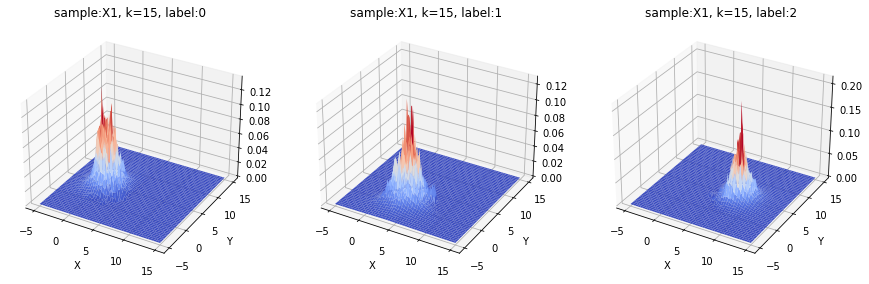

In [26]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=15, label:0")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=15, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=15, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

### k=20

In [27]:
p = Kneibor_Eval(X1, 20)  # 获得概率密度估计

# 高级要求1
X,Y = np.mgrid[-5:15:200j, -5:15:200j]

Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

Text(0.5, 0.92, 'sample:X1, k=20, label:0')

Text(0.5, 0, 'X')

Text(0.5, 0.5, 'Y')

Text(0.5, 0.92, 'sample:X1, k=20, label:1')

Text(0.5, 0, 'X')

Text(0.5, 0.5, 'Y')

Text(0.5, 0.92, 'sample:X1, k=20, label:2')

Text(0.5, 0, 'X')

Text(0.5, 0.5, 'Y')

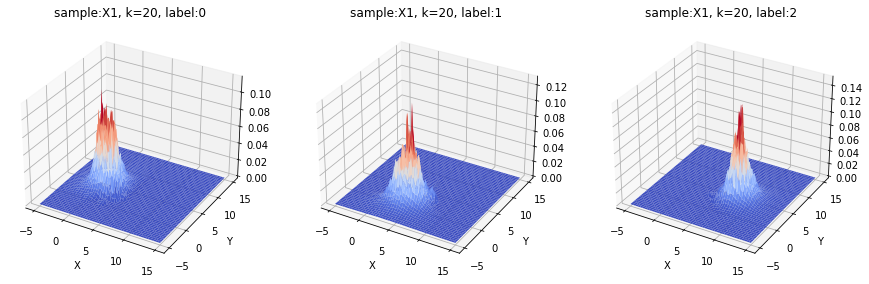

In [28]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=20, label:0")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=20, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=20, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

### k=25

In [29]:
p = Kneibor_Eval(X1, 25)  # 获得概率密度估计

# 高级要求1
X,Y = np.mgrid[-5:15:200j, -5:15:200j]

Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]

Text(0.5, 0.92, 'sample:X1, k=25, label:0')

Text(0.5, 0, 'X')

Text(0.5, 0.5, 'Y')

Text(0.5, 0.92, 'sample:X1, k=25, label:1')

Text(0.5, 0, 'X')

Text(0.5, 0.5, 'Y')

Text(0.5, 0.92, 'sample:X1, k=25, label:2')

Text(0.5, 0, 'X')

Text(0.5, 0.5, 'Y')

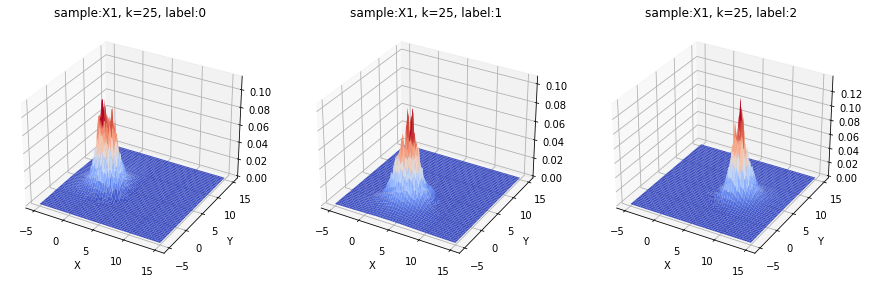

In [30]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=25, label:0")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=25, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=25, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()